In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#lets see what we are dealing with:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22329fae780>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Calculate the date 1 year ago from the last data point in the database

# Latest Date
Last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(Last_date)
# 1 year ago would be 
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

('2017-08-23',)
2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores

#query date and max rainfal across all station, per day (grouped by date) ordered by date
#note - it seems more logical to calculate avg rain across all stations (func.avg()), 
#but func.max returns the same result as shown in the instructions example

Precip = session.query(Measurement.date, func.max(Measurement.prcp)).\
    filter(Measurement.date >= '2016-08-23').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Precip_df = pd.DataFrame(Precip, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
#Already did that while quering...
Precip_df.head()



,Date,Precipitation
0,2016-08-23,1.79
1,2016-08-24,2.28
2,2016-08-25,0.21
3,2016-08-26,0.04
4,2016-08-27,0.18


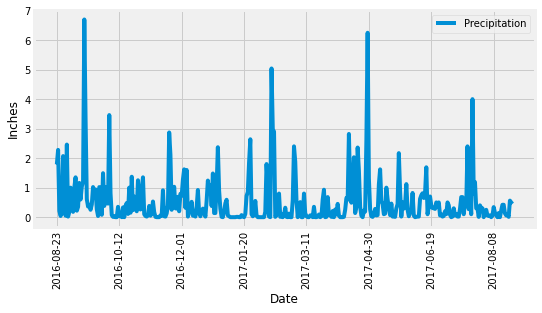

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = Precip_df.plot(x='Date', y='Precipitation', rot=90, x_compat=True, figsize=(8,4))
ax.set_ylabel("Inches")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precip_df.describe()

,Precipitation
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
nos = session.query(Measurement.station).group_by(Measurement.station).count()
print(nos)
#or
nos2 = session.query(Station.station).all()
print(len(nos2))

9
9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#Note not clear over what time period it should be calculated...
active_stations = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()
active_stations
# station USC00519281 has the most prcp observations wtih the past 12 months

[('USC00519281', 2772),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()
print(f"The lowest T recorded was {station_stats[0][0]}F, the highest T was {station_stats[0][1]}F, and the average was {round(station_stats[0][2],0)}F.")
                             


The lowest T recorded was 54.0F, the highest T was 85.0F, and the average was 72.0F.


In [27]:
# Choose the station with the highest number of temperature observations.

#in the past 12 months, or of all time? not clear...
#to reproduce the bar graph in the example, it appears to be of all time (omit date filter)
station_mostT = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
station_mostT

('USC00519281', 2772)

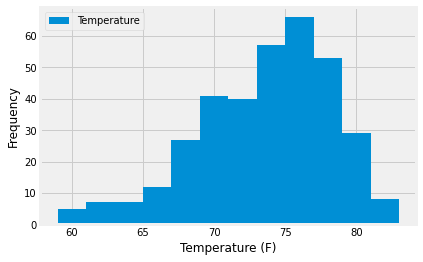

In [35]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == 'USC00519281', Measurement.date >='2016-08-23').all()

Temp_df = pd.DataFrame(Temp, columns=['Date', 'Temperature'])
#Temp_df.head(100)

ax = Temp_df['Temperature'].plot.hist(bins=12, legend='Temperature')
ax.set_xlabel("Temperature (F)")
plt.show()

## Bonus Challenge Assignment

In [115]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
